### Import Packages and Dependencies

In [1]:
import os
import sys
from pathlib import Path

os.chdir(Path(os.getcwd()).parents[0])
sys.path.append(os.getcwd())

from pytorch_lightning import LightningDataModule
from matplotlib.colors import LinearSegmentedColormap
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np
import ast
import fnmatch

/home/l727n/anaconda3/envs/xai-eval/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from src.data.imagenet_datamodule import ImageNetDataModule
from src.data.oct_datamodule import OCTDataModule
from src.data.resisc45_datamodule import RESISC45DataModule

print(sorted(glob.glob("data/attribution_maps/Image/*"), key=os.path.getmtime))

file = sorted(glob.glob("data/attribution_maps/Image/*"), key=os.path.getmtime)[-1] # selects always the newsest
array = np.load(file)
data = [array['arr_0'],array['arr_1'],array['arr_2']]


if fnmatch.fnmatch(file, '*imagenet*'):
    datamodule = ImageNetDataModule(data_dir = "data/datasets/", batch_size = 20)

    with open('data/datasets/imagenet_classes.txt', "r") as cf:
        classes = ast.literal_eval(cf.read())

if fnmatch.fnmatch(file, '*oct*'):
    datamodule = OCTDataModule(data_dir = "data/datasets/", batch_size = 20)
    classes = ["CNV", "DME", "Drusen", "Normal"]
    
if fnmatch.fnmatch(file, '*resisc45*'):
    datamodule = RESISC45DataModule(data_dir = "data/datasets/", batch_size = 20)
    classes = list(datamodule.data.class_to_idx.keys())

dataloader = datamodule.dataloader()

with torch.no_grad():
    x_batch, y_batch = next(iter(dataloader))


['data/attribution_maps/Image/attr_oct_dataset_14_methods_2023-06-20_14-13-19.npz', 'data/attribution_maps/Image/attr_imagenet_dataset_14_methods_2023-06-20_14-13-13.npz', 'data/attribution_maps/Image/attr_resisc45_dataset_14_methods_2023-06-20_14-13-31.npz']


In [10]:
methods = ["Occlusion","LIME (Mask)","Kernel SHAP (Mask)","Saliency","Input x Gradient", "Guided Backprob","GradCAM","ScoreCAM","GradCAM++", "IG", "EG", "Deeplift", "Deeplift SHAP", "LRP", "Raw Attention", "Rollout Attention", "LRP Attention"]
models = ["ResNet50","EfficientNetB0","Deit ViT"]
n = 0
model = 2

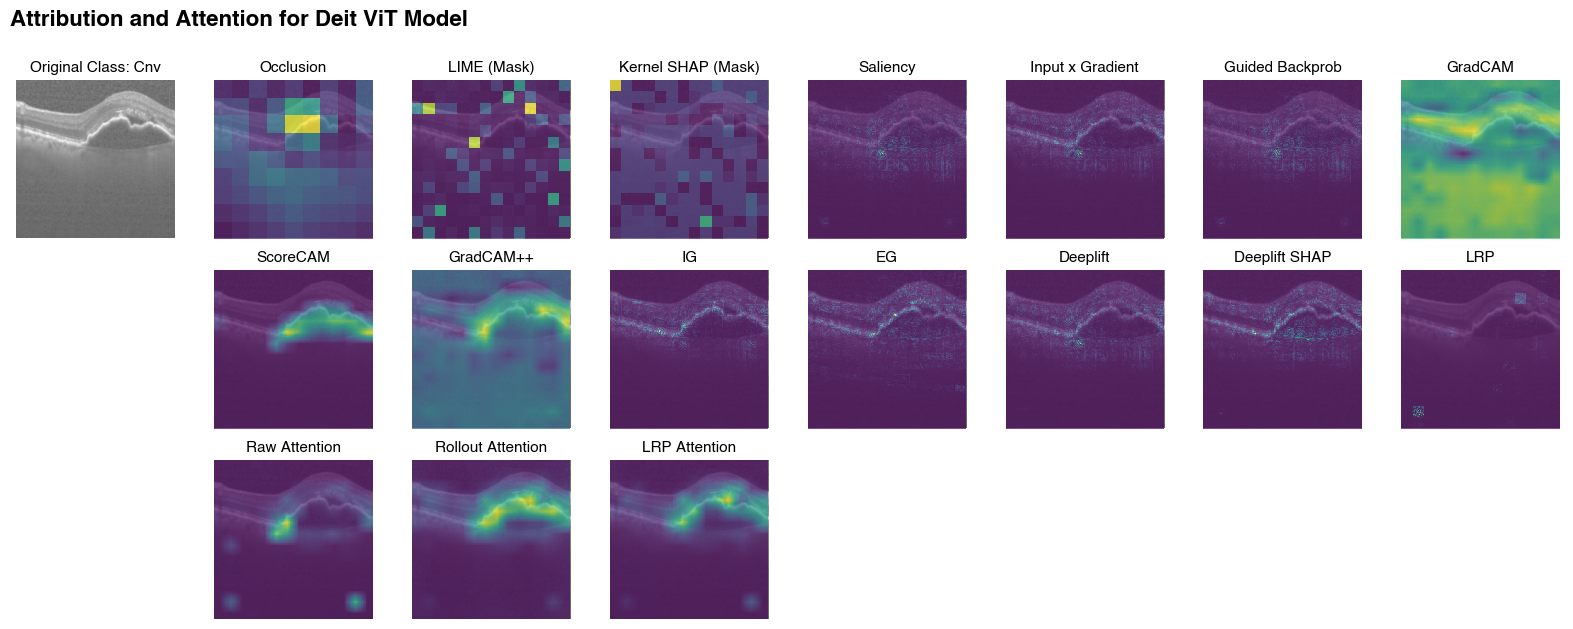

In [11]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['text.color'] = "black"

fig, axes = plt.subplots(3 if model == 2 else 2, 8, figsize=(20, 7) if model == 2 else (21,5), sharey=True, sharex = True)

def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return img

img = deprocess_image(x_batch[n].detach().numpy().transpose(1,2,0))

axes[0,0].imshow(img)
axes[0,0].axis('off')
axes[0,0].axes.set_title("Original Class: " + str(classes[int(y_batch[n])]).title(),fontsize=11)

for i in range(7):
    mask = np.abs(data[model][n,i,:]).mean(0) # obs , XAI, c, w, h
    axes[0,i+1].imshow(img)
    sns.heatmap(ax =  axes[0,(i+1)], data = mask,cbar=False, cmap="viridis", alpha=0.7)
    axes[0,i+1].axis('off')
    axes[0,i+1].axes.set_title(methods[i],fontsize=11)
for i in range(7):
    mask = np.abs(data[model][n,7 + i,:]).mean(0)
    axes[1,i+1].imshow(img)
    sns.heatmap(ax =  axes[1,(i+1)], data = mask,cbar=False, cmap="viridis", alpha=0.7)
    axes[1,i+1].axis('off')
    axes[1,i+1].axes.set_title(methods[7 + i],fontsize=11)


axes[1,0].axis('off')

fig.suptitle("Attribution and Attention for " + models[model] + " Model", fontsize=16, x = 0.251 if model == 1 else 0.238, fontweight='bold')

if model == 2:
    for i in range(3):
        mask = np.abs(data[model][n,14 + i,:]).mean(0)
        axes[2,i+1].imshow(img)
        sns.heatmap(ax =  axes[2,(i+1)], data = mask,cbar=False, cmap="viridis", alpha=0.7)
        axes[2,i+1].axis('off')
        axes[2,i+1].axes.set_title(methods[14 + i],fontsize=11)
    axes[2,0].axis('off')
    axes[2,4].axis('off')
    axes[2,5].axis('off')
    axes[2,6].axis('off')
    axes[2,7].axis('off')

#plt.savefig("data/figures/2D_" + str(datamodule.__name__) + "_" + str(model) + "_Importance.png", dpi = 200, bbox_inches='tight')
